# Preprocessing and exploration of the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

Import the data for the NJ train network. Month of March 2018. Drop the observations with NaN delay.

In [2]:
df = pd.read_csv('2018_03.csv')
df.dropna(subset=['delay_minutes'], inplace=True)
df.reset_index(drop=True, inplace=True)

Remove the weekends to focus on the weekdays. 

In [3]:
idx_weekends = []
for (k,v) in enumerate(df['actual_time']):
    aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
    if aux.day == 6 or aux.day == 7:
        idx_weekends.append(k)
df = df.drop(idx_weekends)
df.reset_index(drop=True, inplace=True)        

In [4]:
df.head(n=5)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [5]:
print(df.columns)
N = df['to'].nunique()
N_obs = df.shape[0]
print('Number of observations:', N_obs)
print('Number of stations:', N)
print('Operators:', df['type'].nunique())
print('Lines:', df['line'].nunique())
print('Trains:', df['train_id'].nunique())

Index(['date', 'train_id', 'stop_sequence', 'from', 'from_id', 'to', 'to_id',
       'scheduled_time', 'actual_time', 'delay_minutes', 'status', 'line',
       'type'],
      dtype='object')
Number of observations: 227345
Number of stations: 165
Operators: 1
Lines: 11
Trains: 1319


Create dictionaries to number stations and lines. Also a dictionary to link stations with lines.

In [6]:
lines_dict = {v:k for (k,v) in enumerate(df['line'].unique())}
lines_dict_inv = {k:v for (k,v) in enumerate(df['line'].unique())}
stations_dict = {v:k for (k,v) in enumerate(df['to'].unique())}
stations_dict_inv = {k:v for (k,v) in enumerate(df['to'].unique())}
stations_lines = {}
for i in range(len(df['line'].unique())):
    for j in range(len(df['from'][df['line']==lines_dict_inv[i]].unique())):
        stations_lines[df['from'][df['line']==lines_dict_inv[i]].unique()[j]] = df['line'].unique()[i]       

Which stations are connected to which?

In [7]:
connections = [[0 for x in range(N)] for y in range(N)]
for i in range(df.shape[0]):
    ii = stations_dict[df['from'][i]]
    jj = stations_dict[df['to'][i]]
    connections[ii][jj] += 1

#real adjacency
adjacency_unweight = [[0 for x in range(N)] for y in range(N)]
edges = []
lines = []
for i in range(N):
    for j in range(N):
        if connections[i][j] != 0:
            adjacency_unweight[i][j] = 1
            edges.append((i,j)) 
            aaa = np.where(((df['from'] == stations_dict_inv[i]) & (df['to'] == stations_dict_inv[j]))==True)[0][0]
            lines.append(df['line'][aaa])       

## Delays

Average delay per station over all data sorted

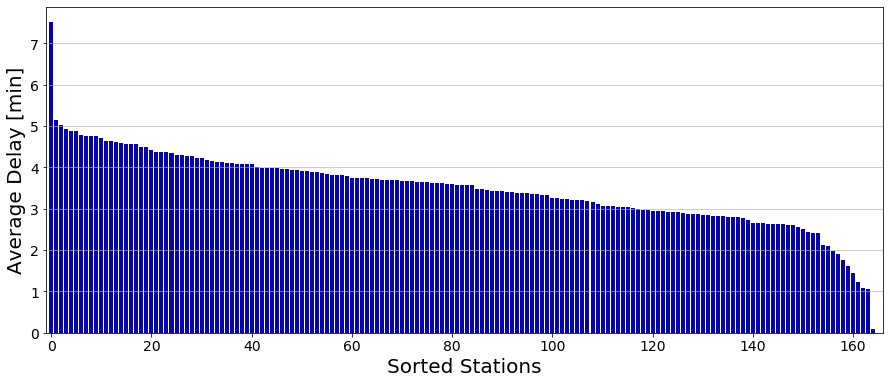

In [8]:
average_delays = []
for i in range(len(stations_dict_inv)):
    average_delays.append(np.mean(df[df['to'] == stations_dict_inv[i]]['delay_minutes']))

fig, ax = plt.subplots(figsize = (15,6))
ax.bar(list(stations_dict.values()), sorted(average_delays, reverse= True), align='center', color='#0504aa')
ax.set_xlabel('Sorted Stations', fontsize = 20)
ax.set_ylabel('Average Delay [min]', fontsize = 20)
ax.grid(axis='y', alpha=0.75)
ax.set_xlim(-1,166)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('horizontal')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('horizontal')
plt.savefig('SortedAverageDelay.png')
plt.show()

Distribution of delays considering 0 values or not

C:\Users\jasso\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


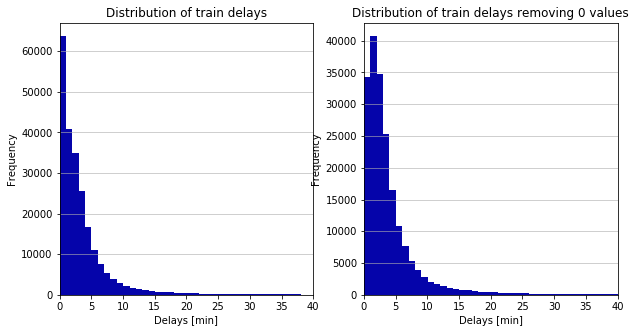

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
ax[0].hist(x=list(df['delay_minutes']), bins = 100, color='#0504aa')
ax[0].grid(axis='y', alpha=0.75)
ax[0].set_xlabel('Delays [min]')
ax[0].set_xlim(0, 40)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of train delays')

delays_0 = [i for i in list(df['delay_minutes']) if i>0]
ax[1].hist(x= delays_0, bins = 100, color='#0504aa')
ax[1].grid(axis='y', alpha=0.75)
ax[1].set_xlabel('Delays [min]')
ax[1].set_xlim(0, 40)
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of train delays removing 0 values')
fig.savefig('Distributions.png')
fig.show()

## Plot and create the network graph

Dictionary for lines and colors

In [10]:
colors = ['red', 'deepskyblue', 'yellow', 'green', 'palegreen', 'orange', 'silver', 'blue', 'lightcoral', 'black' ,'purple']
#colors = ['#6E2C00', '#873600', '#A04000', '#BA4A00', '#D35400', '#DC7633', '#E59866', '#EDBB99', '#CA6F1E', '#E67E22' ,'#F5B041']
lines_color = {lines_dict_inv[i]:colors[i] for i in range(len(lines_dict_inv))}
edges_color = [lines_color[i] for i in lines]  

Creation of the graph of the real network with networkx

In [11]:
import networkx as nx
G_ny = nx.from_numpy_matrix(np.array(adjacency_unweight))
print('Number of nodes: {}, Number of edges: {}'. format(G_ny.number_of_nodes(), G_ny.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_ny.number_of_selfloops(), nx.number_connected_components(G_ny)))

Number of nodes: 165, Number of edges: 315
Number of self-loops: 43, Number of connected components: 2


Import the coordinates of the stations to plot them

In [12]:
coord_all = pd.read_excel('New_Jersey_Railroad.xlsx') 
coord_all.head()

,X,Y,OBJECTID,COUNTY,LATITUDE,LONGITUDE,STATION,RAIL_LINE,MUN_LABEL,ATIS_ID,AMTRAK
0,618521.133867,459008.902745,1,OCEAN,40.092718,-74.048192,Point Pleasant Beach,North Jersey Coast Line,Point Pleasant Beach Borough,RAIL0122,N
1,621972.995730,480099.144357,2,MONMOUTH,40.150567,-74.035460,Spring Lake,North Jersey Coast Line,Spring Lake Borough,RAIL0141,N
2,624196.750797,491047.220558,3,MONMOUTH,40.180589,-74.027296,Belmar,North Jersey Coast Line,Belmar Borough,RAIL0015,N
3,626480.961123,499505.650491,4,MONMOUTH,40.203775,-74.018956,Bradley Beach,North Jersey Coast Line,Bradley Beach Borough,RAIL0022,N
4,627622.289549,503731.988167,5,MONMOUTH,40.215360,-74.014788,Asbury Park,North Jersey Coast Line,Asbury Park City,RAIL0008,N


C:\Users\jasso\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\jasso\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


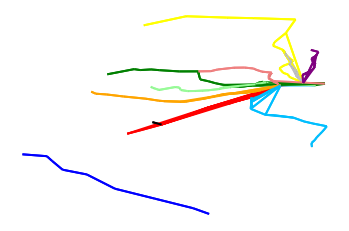

In [13]:
st = list(coord_all['STATION'].to_numpy())
x = list(coord_all['X'].to_numpy())
y = list(coord_all['Y'].to_numpy())
pos_dict = {}
for i in range(len(st)):
    if st[i] in list(df['to'].unique()):
        pos_dict[stations_dict[st[i]]] = np.array([x[i],y[i]])
        
fig, ax = plt.subplots()
nx.draw(G_ny, pos = pos_dict, node_size = 0.001, node_color='dimgrey', edgelist = edges, edge_color = edges_color, width = 2)

fig.savefig('GraphRealNetwork.png')        

Graph feature: degree distribution

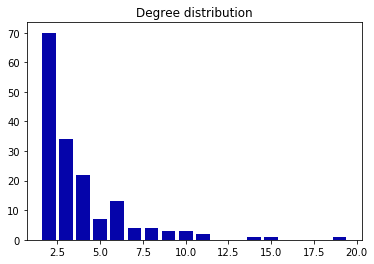

In [14]:
import collections
degree_sequence = sorted([d for n, d in G_ny.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='#0504aa')
plt.title('Degree distribution')
plt.show()
fig.savefig('DegreeDistribution.png')

## Plot the network with different signals

In [15]:
XXX = []
YYY = []
for i in range(len(pos_dict)):
    XXX.append(pos_dict[i][0])
    YYY.append(pos_dict[i][1]) 

In [16]:
def plot_network(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    p = ax.scatter(XXX,YYY, c = x, cmap = 'RdBu_r', vmin=min(x), vmax=max(x))
    ax.set_title(title)
    fig.colorbar(p)

Compute metrics as signal: average delay (already have it), sum of delays over month, median and standard deviation

In [17]:
sum_delays = []
for i in range(len(stations_dict_inv)):
    sum_delays.append(np.sum(df[df['to'] == stations_dict_inv[i]]['delay_minutes']))
    
median_delays = []
for i in range(len(stations_dict_inv)):
    median_delays.append(np.median(df[df['to'] == stations_dict_inv[i]]['delay_minutes']))

std_delays = []
for i in range(len(stations_dict_inv)):
    std_delays.append(np.std(df[df['to'] == stations_dict_inv[i]]['delay_minutes']))    

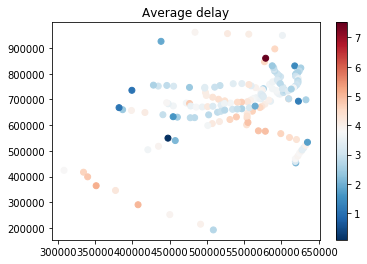

In [18]:
plot_network(average_delays, title = 'Average delay')
plt.savefig('delays_average.png')

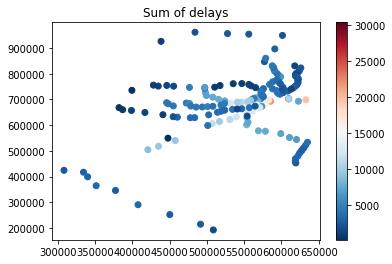

In [19]:
plot_network(sum_delays, title = 'Sum of delays')
plt.savefig('delays_sum.png')

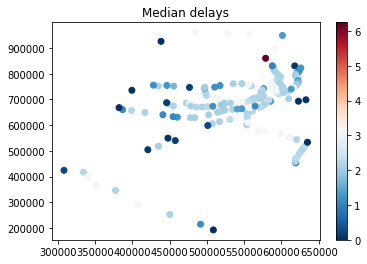

In [20]:
plot_network(median_delays, title = 'Median delays')
plt.savefig('delays_median.png')

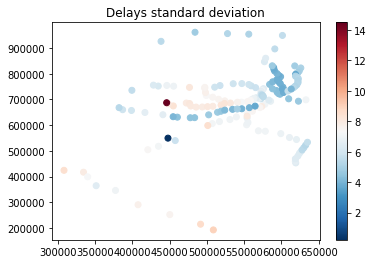

In [21]:
plot_network(std_delays, title = 'Delays standard deviation')
plt.savefig('delays_std.png')

## Dynamic Plotting

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import math

Construct a dataframe for each hour

In [23]:
average_delays_hour = {}
hourly_delays_dataframe = {}
for i in range(0,24,1):
    average_delays_hour[i] = []
    for (k,v) in enumerate(df['actual_time']):
        aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        if aux.hour == i:
            average_delays_hour[i].append(k)
    hourly_delays_dataframe[i] = df.iloc[average_delays_hour[i]]
    hourly_delays_dataframe[i].reset_index(drop=True, inplace=True)            

Average delay per station each hour

In [24]:
hourly_delays = {}
for j in range(0,24,1):
    hourly_delays[j] = []
    for i in range(len(stations_dict_inv)):
        hourly_delays[j].append(np.mean(hourly_delays_dataframe[j][hourly_delays_dataframe[j]['to'] == stations_dict_inv[i]]['delay_minutes']))

for k,v in hourly_delays.items():
    for i in range(len(v)):
        if math.isnan(v[i]):
            hourly_delays[k][i] = 0        

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


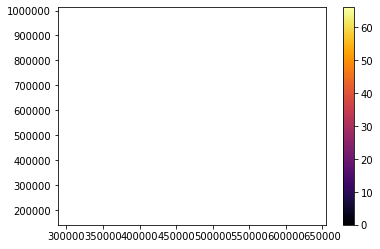

In [25]:
fig, ax = plt.subplots()
ims=[]

for i in range(len(hourly_delays)):
    title = plt.text(0.5,1.01,'Time: '+str(i)+'h', ha="center",va="bottom",
                     transform=ax.transAxes, fontsize="large")
    text = ax.text(i,i,i)
    scatter = ax.scatter(XXX,YYY, c = hourly_delays[i], cmap = 'inferno', vmin=min(hourly_delays[i]), vmax=max(hourly_delays[i]))

    ims.append([text,scatter,title])

fig.colorbar(scatter)
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False,
                              repeat_delay=2000)
ani.save('GIFaverageHourlyDelay.gif')
plt.show()

## Dynamic plotting with filtering

In the following section, the average delays are dynamically plotted per hour but the computation of the station average delay is performed according to whether it is an inward or outward trip. Again we only take into account the weekdays

In [26]:
df_in = pd.read_csv('Inward.csv')
df_out = pd.read_csv('Outward.csv')

In [27]:
idx_weekends_in = []
idx_weekends_out = []
for (k,v) in enumerate(df_in['actual_time']):
    aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
    if aux.day == 6 or aux.day == 7:
        idx_weekends_in.append(k)
        
for (k,v) in enumerate(df_out['actual_time']):
    aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
    if aux.day == 6 or aux.day == 7:
        idx_weekends_out.append(k)
        
df_in = df_in.drop(idx_weekends_in)
df_in.reset_index(drop=True, inplace=True)          
df_out = df_out.drop(idx_weekends_out)
df_out.reset_index(drop=True, inplace=True)   

Inward trips

In [28]:
average_delays_hour = {}
hourly_delays_dataframe = {}
for i in range(0,24,1):
    average_delays_hour[i] = []
    for (k,v) in enumerate(df_in['actual_time']):
        aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        if aux.hour == i:
            average_delays_hour[i].append(k)
    hourly_delays_dataframe[i] = df_in.iloc[average_delays_hour[i]]
    hourly_delays_dataframe[i].reset_index(drop=True, inplace=True)            

In [29]:
hourly_delays = {}
for j in range(0,24,1):
    hourly_delays[j] = []
    for i in range(len(stations_dict_inv)):
        hourly_delays[j].append(np.mean(hourly_delays_dataframe[j][hourly_delays_dataframe[j]['to'] == stations_dict_inv[i]]['delay_minutes']))
        
import math
for k,v in hourly_delays.items():
    for i in range(len(v)):
        if math.isnan(v[i]):
            hourly_delays[k][i] = 0        

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


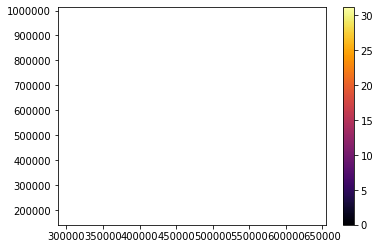

In [30]:
fig, ax = plt.subplots()
ims=[]

for i in range(len(hourly_delays)):
    title = plt.text(0.5,1.01,'Time: '+str(i)+'h', ha="center",va="bottom",
                     transform=ax.transAxes, fontsize="large")
    text = ax.text(i,i,i)
    scatter = ax.scatter(XXX,YYY, c = hourly_delays[i], cmap = 'inferno', vmin=min(hourly_delays[i]), vmax=max(hourly_delays[i]))

    ims.append([text,scatter,title])

fig.colorbar(scatter)
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False,
                              repeat_delay=2000)
ani.save('GIFaverageHourlyDelayInward.gif')
plt.show()

Outwards trips

In [31]:
average_delays_hour = {}
hourly_delays_dataframe = {}
for i in range(0,24,1):
    average_delays_hour[i] = []
    for (k,v) in enumerate(df_out['actual_time']):
        aux = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        if aux.hour == i:
            average_delays_hour[i].append(k)
    hourly_delays_dataframe[i] = df_out.iloc[average_delays_hour[i]]
    hourly_delays_dataframe[i].reset_index(drop=True, inplace=True)            

In [32]:
hourly_delays = {}
for j in range(0,24,1):
    hourly_delays[j] = []
    for i in range(len(stations_dict_inv)):
        hourly_delays[j].append(np.mean(hourly_delays_dataframe[j][hourly_delays_dataframe[j]['to'] == stations_dict_inv[i]]['delay_minutes']))

for k,v in hourly_delays.items():
    for i in range(len(v)):
        if math.isnan(v[i]):
            hourly_delays[k][i] = 0

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


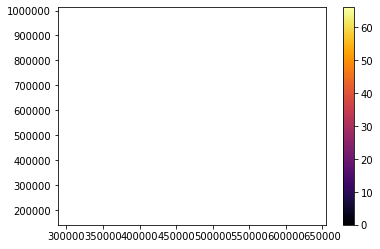

In [33]:
fig, ax = plt.subplots()
ims=[]

for i in range(len(hourly_delays)):
    title = plt.text(0.5,1.01,'Time: '+str(i)+'h', ha="center",va="bottom",
                     transform=ax.transAxes, fontsize="large")
    text = ax.text(i,i,i)
    scatter = ax.scatter(XXX,YYY, c = hourly_delays[i], cmap = 'inferno', vmin=min(hourly_delays[i]), vmax=max(hourly_delays[i]))

    ims.append([text,scatter,title])

fig.colorbar(scatter)
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False,
                              repeat_delay=2000)
ani.save('GIFaverageHourlyDelayOutward.gif')
plt.show()